In [0]:
import tensorflow as tf
import sklearn
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
import matplotlib.pyplot as plt
from tqdm.notebook import trange,tqdm

In [2]:
(train_images,train_labels),(_,_)=keras.datasets.mnist.load_data()
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype("float32")

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images=(train_images-127.5)/255

In [0]:
BUFFER_SIZE=60000
BATCH_SIZE=256
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
discriminator_model=keras.Sequential()
discriminator_model.add(keras.layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
discriminator_model.add(keras.layers.LeakyReLU())
discriminator_model.add(keras.layers.Dropout(0.3))
discriminator_model.add(keras.layers.Flatten())
discriminator_model.add(keras.layers.Dense(1))

# discriminator_model.summary()

In [0]:
generator_model=keras.Sequential()
generator_model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator_model.add(keras.layers.BatchNormalization())
generator_model.add(keras.layers.LeakyReLU())
generator_model.add(keras.layers.Reshape((7,7,256)))
generator_model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator_model.add(keras.layers.BatchNormalization())
generator_model.add(keras.layers.LeakyReLU())
generator_model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator_model.add(keras.layers.BatchNormalization())
generator_model.add(keras.layers.LeakyReLU())
generator_model.add(keras.layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))

# generator_model.summary()

In [7]:
noise = tf.random.normal([100, 100])
generated_image = generator_model(noise, training=False)

print(generated_image.shape)

(100, 28, 28, 1)


In [0]:
cross_entropy=keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
def generator_loss(fake_output):
  gen_loss=cross_entropy(tf.ones_like(fake_output),fake_output)
  return gen_loss

def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [0]:
generator_optimizer=keras.optimizers.Adam(1e-4)
discriminator_optimizer=keras.optimizers.Adam(1e-4)

In [0]:
@tf.function
def train_step(images):
    noise=tf.random.normal([BATCH_SIZE,100])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
      generated_images=generator_model(noise,training=True)

      real_output=discriminator_model(images,training=True)
      fake_output=discriminator_model(generated_images,training=True)

      gen_loss=generator_loss(fake_output)
      disc_loss=discriminator_loss(real_output,fake_output)

    gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator_model.trainable_variables)
    gradients_of_generator=gen_tape.gradient(gen_loss,generator_model.trainable_variables)
    print("generator :",gradients_of_generator)
    print("discriminator :",gradients_of_discriminator)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator_model.trainable_variables))

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def train(dataset,epochs):
  for epoch in trange(epochs):
    for image_batch in dataset:
      train_step(image_batch)

In [15]:
train(train_dataset,EPOCHS)

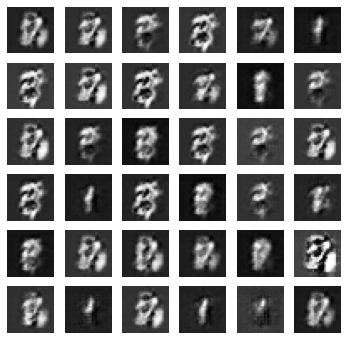

In [26]:
test_noise=tf.random.normal([36,100])
pred=generator_model.predict(test_noise)
pred=pred*255+127.5
fig=plt.figure(figsize=(6,6))
for i in range(pred.shape[0]):
  plt.subplot(6,6,i+1)
  plt.imshow(pred[i,:,:,0],cmap="gray")
  plt.axis("off")